In [3]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import matplotlib.pyplot as plt

from Helpers import create_rolling_windows 

In [4]:
'''
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"
'''

'\ntext_file = keras.utils.get_file(\n    fname="spa-eng.zip",\n    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",\n    extract=True,\n)\ntext_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"\n'

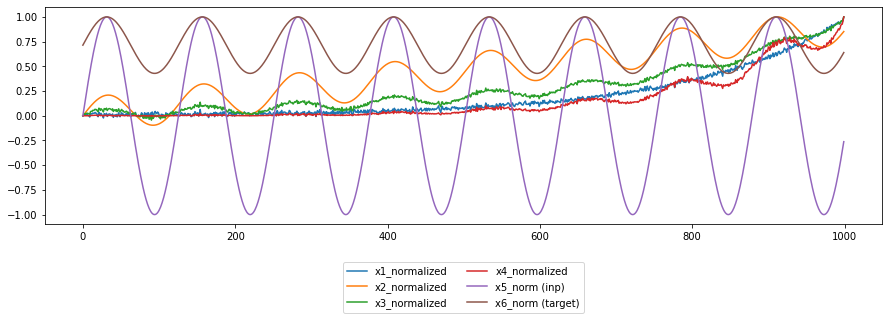

In [23]:
# Create surrogate sample data 

surrogate_samples = 1000
t = np.linspace(0, 50, surrogate_samples)

# inputs, outputs 
x1 = np.exp(0.1 * t) + np.random.normal(0, 2, surrogate_samples)
x2 = 10 * np.sin(t) + t 
x3 = x1 + x2 
x4 = x1 * x2 / 100 
x5 = np.sin(t) * 0.8
x6 = x5 * 0.2 + 0.4

x1_factor = np.max(np.abs(x1))
x2_factor = np.max(np.abs(x2))
x3_factor = np.max(np.abs(x3))
x4_factor = np.max(np.abs(x4))
x5_factor = np.max(np.abs(x5))
x6_factor = np.max(np.abs(x6))


# normalize per time series
x1_normalized = x1 / x1_factor
x2_normalized = x2 / x2_factor
x3_normalized = x3 / x3_factor
x4_normalized = x4 / x4_factor
x5_normalized = x5 / x5_factor
x6_normalized = x6 / x6_factor


plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_normalized)), x1_normalized, label='x1_normalized')
plt.plot(range(len(x2_normalized)), x2_normalized, label='x2_normalized')
plt.plot(range(len(x3_normalized)), x3_normalized, label='x3_normalized')
plt.plot(range(len(x4_normalized)), x4_normalized, label='x4_normalized')
plt.plot(range(len(x5_normalized)), x5_normalized, label='x5_norm (inp)')
plt.plot(range(len(x6_normalized)), x6_normalized, label='x6_norm (target)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
[400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442 443 444 445 

'\nwith open(text_file) as f:\n    lines = f.read().split("\n")[:-1]\ntext_pairs = []\nfor line in lines:\n    eng, spa = line.split("\t")\n    spa = "[start] " + spa + " [end]"\n    text_pairs.append((eng, spa))\n'

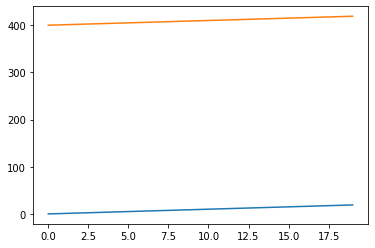

In [70]:
# Create input and target datasets 

'''
seq_length = 20
batch_size = 128 
input_dataset = timeseries_dataset_from_array(data=x5_normalized,targets=None, sequence_length = seq_length, sequence_stride = 1, batch_size = batch_size, shuffle = False)
target_dataset = timeseries_dataset_from_array(data=x6_normalized,targets=None, sequence_length = seq_length, sequence_stride = 1, batch_size = batch_size, shuffle = False)

# check data is correctly cut 
for batch in zip(input_dataset, target_dataset):
    inputs, targets = batch
    
    assert np.array_equal(inputs[0], x5_normalized[:seq_length])
    assert np.array_equal(targets[1], x6_normalized[1:seq_length + 1])
    break
'''    


# datas.as_numpy_iterator())[-1]

# generate pairs (old way)


x5_normalized = np.arange(200) # / 400

print(x5_normalized)

x6_normalized = np.arange(400,600) #/ 600

print(x6_normalized)

surrogate_data = np.array([x5_normalized,x6_normalized]).T
surrogate_pairs = create_rolling_windows(surrogate_data,20)
surrogate_pairs = np.swapaxes(surrogate_pairs,1,2)
print("Shape surrogate pairs: " + str(surrogate_pairs.shape))

plt.plot(surrogate_pairs[0][0])
plt.plot(surrogate_pairs[0][1])



'''
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))
'''

In [71]:
val_frac = 0.15 # amount of val; amount of test 

random.shuffle(surrogate_pairs)
num_val_samples = int(val_frac * len(surrogate_pairs))
num_train_samples = len(surrogate_pairs) - 2 * num_val_samples
train_pairs = surrogate_pairs[:num_train_samples]
val_pairs = surrogate_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = surrogate_pairs[num_train_samples + num_val_samples :]

print(f"{len(surrogate_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")


'''
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")
'''

181 total pairs
127 training pairs
27 validation pairs
27 test pairs


'\nrandom.shuffle(text_pairs)\nnum_val_samples = int(0.15 * len(text_pairs))\nnum_train_samples = len(text_pairs) - 2 * num_val_samples\ntrain_pairs = text_pairs[:num_train_samples]\nval_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]\ntest_pairs = text_pairs[num_train_samples + num_val_samples :]\n\nprint(f"{len(text_pairs)} total pairs")\nprint(f"{len(train_pairs)} training pairs")\nprint(f"{len(val_pairs)} validation pairs")\nprint(f"{len(test_pairs)} test pairs")\n'

In [79]:
# Split pairs into inp and target 
train_inp_seqs = [pair[0] for pair in train_pairs]
train_target_seqs = [pair[1] for pair in train_pairs]
val_inp_seqs = [pair[0] for pair in val_pairs]
val_target_seqs = [pair[1] for pair in val_pairs]

print(np.shape(train_inp_seqs))
print(np.shape(train_target_seqs))
print(np.shape(val_inp_seqs))
print(np.shape(val_target_seqs))

batch_size = 128
sequence_length = 20
vocab_size = 15000

'''
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)
'''

(127, 20)
(127, 20)
(27, 20)
(27, 20)


'\nstrip_chars = string.punctuation + "¿"\nstrip_chars = strip_chars.replace("[", "")\nstrip_chars = strip_chars.replace("]", "")\n\nvocab_size = 15000\nsequence_length = 20\nbatch_size = 64\n\n\ndef custom_standardization(input_string):\n    lowercase = tf.strings.lower(input_string)\n    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")\n\n\neng_vectorization = TextVectorization(\n    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,\n)\nspa_vectorization = TextVectorization(\n    max_tokens=vocab_size,\n    output_mode="int",\n    output_sequence_length=sequence_length + 1,\n    standardize=custom_standardization,\n)\ntrain_eng_texts = [pair[0] for pair in train_pairs]\ntrain_spa_texts = [pair[1] for pair in train_pairs]\neng_vectorization.adapt(train_eng_texts)\nspa_vectorization.adapt(train_spa_texts)\n'

In [120]:
        
def make_dataset(input_seqs,target_seqs):
    ###input_seqs, target_seqs = zip(*pairs)
    #print(input_seqs)
    #print(target_seqs)
    ###input_seqs = list(input_seqs)
    ###target_seqs = list(target_seqs)
    
    # Create dataset with inp sequence <-> target sequence pairs (both have length sequence_length)
    dataset = tf.data.Dataset.from_tensor_slices((input_seqs, target_seqs)) # tuple makes sure that inp matches correct target

    # batch 
    dataset = dataset.batch(batch_size)
    
    # format input/ outputs omitting last elem for decoder input and skipping first elem for target 
    # idea: instead of "word by word", show everything and do not omit first or last 
    dataset = dataset.map(format_dataset)
    
    return dataset.shuffle(2048).prefetch(16).cache()



def format_dataset(inp, target):
    #inp = inp_vectorization(inp)
    #target = target_vectorization(target)
    
    print("format")
    for elem in inp:
        print(elem)
    print(np.shape(inp))
    print(np.shape(target))
    
    # why these indices for target? likely: idea of this transformer architecture, proceed word by word
    #return ({"encoder_inputs": inp, "decoder_inputs": target[:, :-1],}, target[:, 1:])
    #return ({"encoder_inputs": inp, "decoder_inputs": target[:, :-1],}, target)
    return ({"encoder_inputs": inp, "decoder_inputs": target}, target)


'''
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()
'''

train_ds = make_dataset(train_inp_seqs,train_target_seqs)
val_ds = make_dataset(val_inp_seqs,val_target_seqs)

format
Tensor("while/TensorArrayV2Read/TensorListGetItem:0", shape=(20,), dtype=int64)
(None, 20)
(None, 20)
format
Tensor("while/TensorArrayV2Read/TensorListGetItem:0", shape=(20,), dtype=int64)
(None, 20)
(None, 20)


In [121]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (127, 20)
inputs["decoder_inputs"].shape: (127, 20)
targets.shape: (127, 20)


In [152]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        
        ### no need for token embedding 
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim 
        )
        ###
        
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        ### no need for token embedding 
        embedded_tokens = self.token_embeddings(inputs)
        ### 
        
        embedded_positions = self.position_embeddings(positions)
        
        '''
        print(embedded_tokens)
        print(embedded_positions)
        print(inputs)
        print()
        print(embedded_positions + inputs)
        '''
        
        return embedded_tokens + embedded_positions # original
        #return tf.expand_dims(embedded_positions, axis=0)
        #return embedded_positions + inputs # no need for token embedding, instead add actual numbers 
        
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [157]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="float64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="float64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)

# decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x) # orig
decoder_outputs = layers.Dense(sequence_length, activation="softmax")(x)

decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
'''
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
'''

'\nembed_dim = 256\nlatent_dim = 2048\nnum_heads = 8\n\nencoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")\nx = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)\nencoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)\nencoder = keras.Model(encoder_inputs, encoder_outputs)\n\ndecoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")\nencoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")\nx = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)\nx = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)\nx = layers.Dropout(0.5)(x)\ndecoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)\ndecoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)\n\ndecoder_outputs = decoder([decoder_inputs, encoder_outputs])\ntransformer = keras.Model(\n    [encoder_inputs, decoder_inputs], decoder_o

In [158]:
epochs = 1  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="mse", metrics=["accuracy"] # sparse_categorical_crossentropy
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding_46 (Positi (None, None, 256)    3845120     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder_27 (Transfo (None, None, 256)    3155456     positional_embedding_46[0][0]    
________________________________________________________________________________________

InvalidArgumentError:  Incompatible shapes: [127,20,20] vs. [127,20]
	 [[node gradient_tape/mean_squared_error/BroadcastGradientArgs (defined at <ipython-input-158-503ad0a05bfc>:7) ]] [Op:__inference_train_function_65066]

Function call stack:
train_function


In [39]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

NameError: name 'spa_vectorization' is not defined